# Steam Workshop Downloader

Make sure you have `steamctl` installed. Use `pip install steamctl` to install it.

Edit the `private` file:
- first line should contain 'api XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
- second line should contain 'domain https:/your-domain.com'

You can obtain a Steam API key [here](https://steamcommunity.com/login/home/?goto=%2Fdev%2Fapikey). You can use your Steam profile URL as domain.

In [1]:
import os
import requests
import shutil

from tqdm.notebook import tqdm, trange
from bs4 import BeautifulSoup

Settings

- `N_PAGES`: Integer, Number of pages to scrap
- `APP_ID`: Integer, Steam application's ID (Space Engineers' is 244850)
- `FILTER`: String, arbitrary filter
- `SORT`: String, one of 'trend', 'mostrecent', 'lastupdated', 'totaluniquesubscribers'

In [2]:
N_PAGES = 2 # number of pages to scrap
APP_ID = 244850  # the Space Engineers App ID
FILTER = 'spaceship'  # filter string
SORT = 'mostrecent'  # sorting order

API_KEY = ''
DOMAIN = ''

Create a directory to place the downloaded content.

In [3]:
os.makedirs('downloads', exist_ok=True)

Update the API_KEY in `steamctl`

In [4]:
with open('private', 'r') as f:
    ls = f.readlines()
    API_KEY = ls[0].strip().split(' ')[1]
    DOMAIN = ls[1].strip().split(' ')[1]

res = os.popen(f'steamctl webapi set-key {API_KEY}').read()
if not res.startswith('Current'):
    print('Error setting API key; check console.')

Scrape Workshop page to get the entries IDs

In [5]:
file_ids = []

for n in trange(N_PAGES, desc='Scraping workshop pages'):
    page_url = f'https://steamcommunity.com/workshop/browse/?appid={APP_ID}&searchtext={FILTER}&browsesort={SORT}&section=home&actualsort={SORT}&p={n}'
    response = requests.get(page_url)
    soup = BeautifulSoup(response.text)
    entries = soup.find_all('a', class_='ugc')
    
    for entry in entries:
        file_ids.append(entry.get('data-publishedfileid'))

Scraping workshop pages:   0%|          | 0/2 [00:00<?, ?it/s]

Download each entry in its own folder

In [6]:
for i in trange(len(file_ids), desc='Downloading content'):
    file_id = file_ids[i]
    os.makedirs(f'downloads/{file_id}', exist_ok=True)
    os.popen(f'cd downloads/{file_id} && steamctl workshop download --anonymous {file_id}').read()

Remove content that does not contain structure blueprints (i.e.: does not contain any `.sbc` file)

In [7]:
subdirs = os.listdir('downloads')

to_remove = []

for subdir in subdirs:
    files = os.listdir(os.path.join('downloads', subdir))
    if len(files) != 4 or files[0] != 'bp.sbc':
        to_remove.append(os.path.join('downloads', subdir))

for i in trange(len(to_remove), desc='Removing bad folders'):
    shutil.rmtree(to_remove[i])

Removing bad folders:   0%|          | 0/4 [00:00<?, ?it/s]

Rename all `bp.sbc` files in each valid directory with the directory name (ID) and move them to a separate folder.

In [8]:
subdirs = os.listdir('downloads')

os.makedirs('content', exist_ok=True)

for i in trange(len(subdirs), desc='Moving content and cleaning downloads'):
    content_dir = os.path.join('downloads', subdirs[i])
    shutil.move(os.path.join(content_dir, 'bp.sbc'),
                os.path.join('content', f'{subdirs[i]}.sbc'))
shutil.rmtree('downloads')

Moving content and cleaning downloads:   0%|          | 0/26 [00:00<?, ?it/s]

### Convert `sbc`s to a `Structure`

Convert the `sbc` files to a `Structure`. This will be moved to the `pcgsepy.common.api_call` once working properly. 

In [73]:
from pcgsepy.structure import *
from pcgsepy.common.vecs import *
from pcgsepy.common.api_call import *

import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET

sbc_file = os.path.join('content/2560343403.sbc')
root = ET.parse(sbc_file).getroot()

In [74]:
to_orientation = {
    'Up': Orientation.UP,
    'Down': Orientation.DOWN,
    'Left': Orientation.LEFT,
    'Right': Orientation.RIGHT,
    'Forward': Orientation.FORWARD,
    'Backward': Orientation.BACKWARD
}

In [75]:
STRUCTURE_DIM = 100
structure = Structure(origin=Vec.v3f(0., 0., 0.),
                        orientation_forward=Orientation.FORWARD.value,
                        orientation_up=Orientation.UP.value,
                        dimensions=(STRUCTURE_DIM, STRUCTURE_DIM, STRUCTURE_DIM))

for n, child in enumerate(root[0][0][2][0][6]):  #  CubeBlocks node
    block_type = ''
    position = (0, 0, 0)
    orientations = {'Forward': Orientation.FORWARD, 'Up': Orientation.UP}  # to change
    for i, p in enumerate(child):
        if p.tag == 'SubtypeName':
            block_type = p.text
        elif p.tag == 'Min':
            position = (int(p.attrib['x']), int(p.attrib['y']), int(p.attrib['z']))
        elif p.tag == 'BlockOrientation':
            orientations = {
                'Forward': to_orientation[p.attrib['Forward']],
                'Up': to_orientation[p.attrib['Up']]
            }
    if not block_type:
        continue
    block = Block(block_type=block_type,
                  orientation_forward=orientations['Forward'],
                  orientation_up=orientations['Up'])
    structure.add_block(block=block,
                        grid_position=((STRUCTURE_DIM // 2) + position[0],
                                       (STRUCTURE_DIM // 2) + position[1],
                                       (STRUCTURE_DIM // 2) + position[2]))

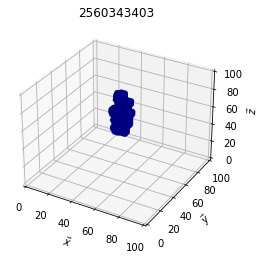

In [76]:
def plot_structure(structure: Structure,
                    title: str,
                    axis_limits: Tuple[int, int, int]) -> None:
        %matplotlib inline
        ax = plt.axes(projection='3d')
        arr = structure._structure != structure._VALUE
        x, y, z = np.nonzero(arr)
        ax.scatter(x, y, z, c=np.ones(len(x)), cmap='jet', linewidth=0.1)
        ax.set_xlim3d(0, axis_limits[0])
        ax.set_ylim3d(0, axis_limits[1])
        ax.set_zlim3d(0, axis_limits[2])
        ax.set_xlabel("$\\vec{x}$")
        ax.set_ylabel("$\\vec{y}$")
        ax.set_zlabel("$\\vec{z}$")
        plt.title(title)
        plt.show()

plot_structure(structure=structure,
               title='2560343403',
               axis_limits=(STRUCTURE_DIM, STRUCTURE_DIM, STRUCTURE_DIM))

Spawn structure in game

In [77]:
base_position, orientation_forward, orientation_up = get_base_values()
structure.update(origin=base_position,
                 orientation_forward=orientation_forward,
                 orientation_up=orientation_up)
toggle_gamemode(GameMode.PLACING)
place_blocks(structure.get_all_blocks())
toggle_gamemode(GameMode.EVALUATING)